In [5]:
import warnings
warnings.filterwarnings("ignore",message="pkg_resources is deprecated")

In [8]:
print(f"*" * 100 + "\n**** Welcome to Taxi V3 Toy Text Project" + ",a Reinforcement Learning" + "\n**** " + "implementation utilizing Q-Learning,a model-free approach for solving games")
print(f"****" + " Experimented by:\n**** Bimal Thapa Magar")
print(f"*" * 100)

****************************************************************************************************
**** Welcome to Taxi V3 Toy Text Project,a Reinforcement Learning
**** implementation utilizing Q-Learning,a model-free approach for solving games
**** Experimented by:
**** Bimal Thapa Magar
****************************************************************************************************


In [11]:
from pyvirtualdisplay import Display
import numpy as np
import gymnasium as gym
import random
import tqdm
import imageio
import imageio_ffmpeg
from tqdm.notebook import trange

In [13]:
virtual_display = Display(visible=False,size=(1400,900))
virtual_display.start()

In [15]:
env = gym.make('Taxi-v3',render_mode="rgb_array")

In [20]:
print("OBSERVATION SPACE \n")
obs_space = env.observation_space
print(f"Total states: {obs_space.n}")
print(f"Sample Observation: {obs_space.sample()}")

OBSERVATION SPACE 

Total states: 500
Sample Observation: 76


In [22]:
print("ACTION SPACE \n")
act_space = env.action_space
print(f"Total actions: {act_space.n}")
print(f"Sample action: {act_space.sample()}")

ACTION SPACE 

Total actions: 6
Sample action: 4


In [30]:
def init_q_table(num_states,num_actions):
    Qtable = np.zeros((num_states,num_actions))
    return Qtable
print("Initial Q-Table samples:")
sample_q = init_q_table(obs_space.n,act_space.n)
print(sample_q)
print(f"{sample_q.shape} ---> {sample_q.shape[0]} states and {sample_q.shape[1]} actions")

Initial Q-Table samples:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
(500, 6) ---> 500 states and 6 actions


In [35]:
def epsilon_greedy_policy(state,QTable,epsilon):
    random_prob = random.uniform(0,1)
    if random_prob > epsilon:
        action = np.argmax(QTable[state])
    else:
        action = env.action_space.sample()
    return action

In [34]:
TRAIN_EPISODES = 10000
LEARNING_RATE = 0.7
TEST_EPISODES = 1000
SEED = 42
MAX_STEPS = 99
MAX_EPSILON = 1
MIN_EPSILON = 0.005
DECAY_RATE = 0.0005
GAMMA = 0.95

In [45]:
# Training loop
def train(episodes,QTable):
    for episode in trange(episodes):
        epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp( - DECAY_RATE * episode)
        state = env.reset()[0]
        terminated = False

        for step in range(MAX_STEPS):
            action = epsilon_greedy_policy(state,QTable,epsilon)
            new_state,reward,terminated,_,info = env.step(action)
            
            QTable[state][action] = QTable[state][action] + LEARNING_RATE * (reward + GAMMA * np.max(QTable[new_state]) - QTable[state][action])

            if terminated:
                break
            state = new_state
    return QTable

In [67]:
QTable = init_q_table(obs_space.n,act_space.n)
print(QTable)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [68]:
final_q_table = train(TRAIN_EPISODES,QTable)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [69]:
final_q_table

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 2.75200369,  3.94947757,  2.75200369,  3.94947757,  5.20997639,
        -5.05052243],
       [ 7.93349184,  9.40367562,  7.93349184,  9.40367562, 10.9512375 ,
         0.40367562],
       ...,
       [10.9512375 , 12.58025   , 10.9512375 ,  9.40367562,  1.9512375 ,
         1.9512375 ],
       [ 5.20978581,  6.53679835,  5.20966901,  6.53681725, -3.80809221,
        -3.79021346],
       [16.09999611, 14.29499217, 16.09989419, 18.        ,  7.099997  ,
         7.09999251]], shape=(500, 6))

In [70]:
def evaluate_agent(episodes,QTable,seed):
    episode_rewards = []
    for episode in range(episodes):
        if seed:
            state = env.reset(seed = seed)[0]
        else:
            state = env.reset()[0]
        terminated = False
        total_rewards_ep = 0

        for step in range(MAX_STEPS):
            action = np.argmax(QTable[state])
            new_state,reward,terminated,_,info = env.step(action)
            total_rewards_ep += reward

            if terminated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward,std_reward

In [71]:
mean_reward,std_reward = evaluate_agent(TEST_EPISODES,QTable,42)
print(f"Mean Reward: {mean_reward}, Standard Deviation: {std_reward}")

Mean Reward: 8.0, Standard Deviation: 0.0


In [72]:
def record_video(QTable,env,out_directory,fps,seed):
    images = []
    terminated = False
    state = env.reset(seed = seed)[0]
    img = env.render()
    images.append(img)

    while not terminated:
        action = np.argmax(QTable[state])
        state,_,terminated,_,_ = env.step(action)
        img = env.render()
        images.append(img)
    imageio.mimsave(out_directory,[np.array(img) for i,img in enumerate(images)],fps=fps,loop=0)

In [74]:
VIDEO_PATH = "final_game.gif"
VIDEO_FPS = 1

In [77]:
record_video(final_q_table,env,VIDEO_PATH,VIDEO_FPS,SEED)

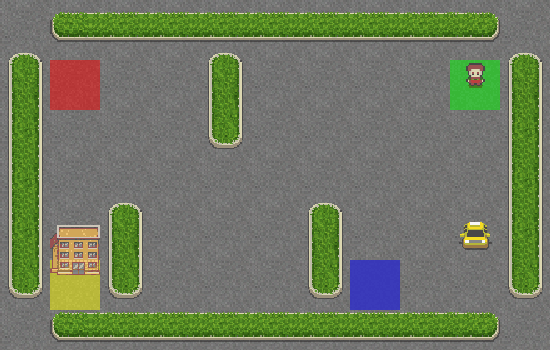

In [78]:
from IPython.display import Image
Image(VIDEO_PATH)